In [35]:
# %load_ext autoreload
# %autoreload 2

import sys
sys.path.append('..')

from events_calc import precip_events
from lib.obs import hourly_precip
from lib.enso import oni_trimonthly

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load precip data and apply clustering analysis

In [2]:
dfs = []
eps = 6
min_samples = 6
date_ = pd.Timestamp('1960-07-01')
batch = 0

# suppress warnings
pd.options.mode.chained_assignment = None

while date_ < pd.Timestamp('2020-01-01'):
    time_interval = (date_, date_ + pd.Timedelta(365, 'D'))
    rainfall = hourly_precip('SFO', *time_interval)
    rainfall = rainfall[rainfall.precip_in >= 0.01]
    rainfall['clust'] = precip_events(rainfall, eps, min_samples)
    
    max_cluster = rainfall['clust'].max()
    df_to_add = rainfall[rainfall.clust >= 0]
    df_to_add['clust'] += batch
    dfs.append(df_to_add)
    
    date_ = date_ + pd.Timedelta(365, 'D')
    batch += max_cluster
    
dfs_combined = pd.concat(dfs)

In [74]:
rain_events = dfs_combined.groupby('clust', as_index=False).agg({
    'precip_in': sum,
    'valid': [lambda r: pd.Timestamp(np.nanmean([tsp.value for tsp in r]))]
})
rain_events.columns.droplevel(level=0)
rain_events.columns = ['clust', 'precip', 'mean_time']
rain_events['month'] = rain_events.mean_time.dt.month
rain_events['year'] = rain_events.mean_time.dt.year

In [75]:
rain_events.sort_values(by='precip', ascending=False).head()

,clust,precip,mean_time,month,year
73,73,6.91,1962-10-13 03:54:53.617021280,10,1962
721,721,6.51,1982-01-04 17:09:05.454545472,1,1982
210,210,5.98,1967-01-21 08:30:00.000000000,1,1967
1231,1231,4.14,1995-12-12 02:10:35.294117632,12,1995
1332,1332,3.82,1998-02-03 03:46:00.000000000,2,1998


# Look at rainfall distribution of rain events

In [10]:
rain_events.precip.describe()

count    2152.000000
mean        0.504986
std         0.602694
min         0.060000
25%         0.130000
50%         0.290000
75%         0.650000
max         6.910000
Name: precip, dtype: float64

Text(0, 0.5, 'Count')

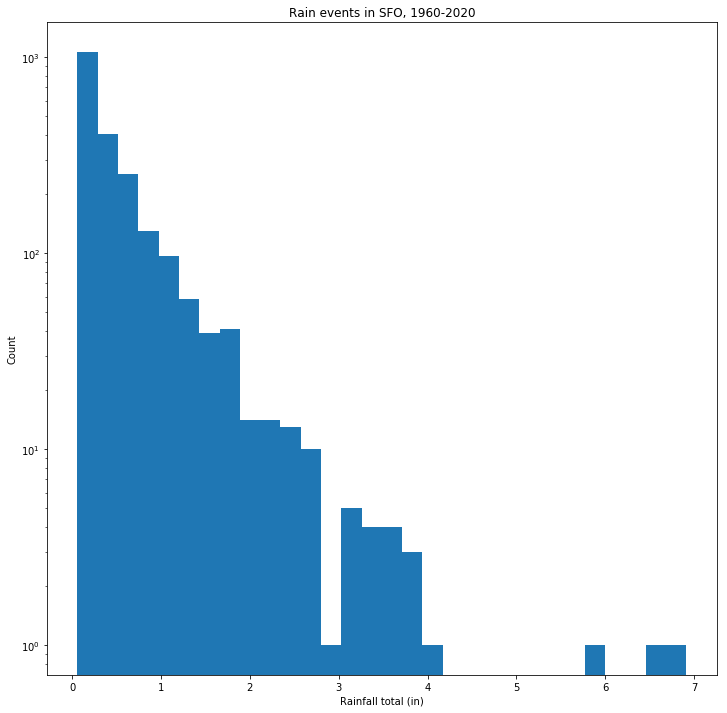

In [7]:
plt.figure(figsize=(12, 12))
plt.hist(rain_events.precip, bins=30, log=True)
plt.title('Rain events in SFO, 1960-2020')
plt.xlabel('Rainfall total (in)')
plt.ylabel('Count')

# Rain events vs. ENSO (ONI)

In [36]:
oni = oni_trimonthly()

In [102]:
def get_oni(t):
    month = t.month
    year = t.year
    oni_val = oni[(oni.MONTH == month) & (oni.YR == year)]['ANOM']
    return float(oni_val)

rain_events['oni'] = rain_events['mean_time'].apply(get_oni)

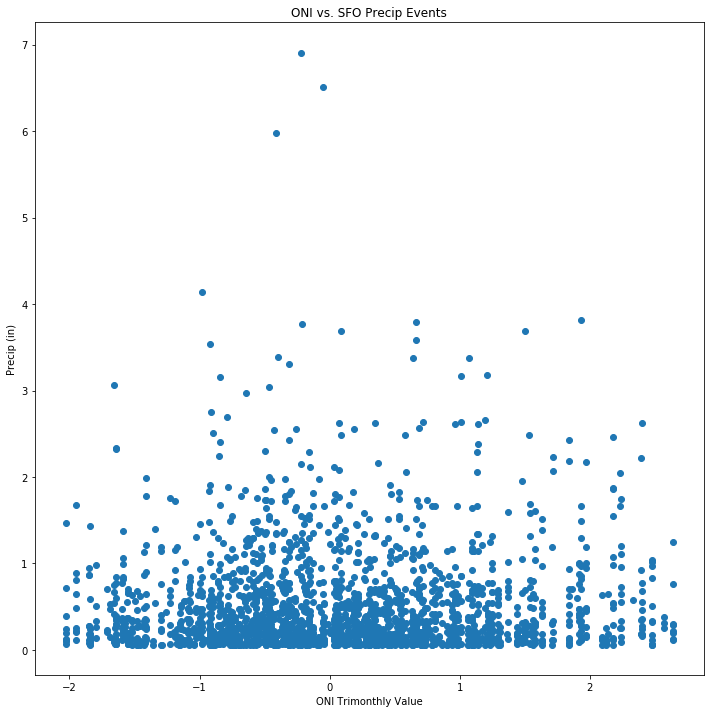

In [67]:
plt.figure(figsize=(12, 12))
plt.title('ONI vs. SFO Precip Events')
plt.xlabel('ONI Trimonthly Value')
plt.ylabel('Precip (in)')
plt.scatter(rain_events.oni, rain_events.precip)

In [201]:
rain_events['enso'] = pd.cut(rain_events.oni, [-4, -1.495, -0.5, 0.5, 1.495, 4], labels=[
    'strong_nina', 'weak_nina', 'neutral', 'weak_nino', 'strong_nino'
])

In [202]:
enso_counts = rain_events.groupby(['year', 'month'], as_index=False).first().enso.value_counts()

In [203]:
enso_counts

neutral        209
weak_nina      113
weak_nino      102
strong_nino     31
strong_nina     23
Name: enso, dtype: int64

In [204]:
for enso_group in ('strong_nino', 'weak_nino', 'neutral', 'weak_nina', 'strong_nina'):
    precips = rain_events[rain_events.enso == enso_group].precip.sum() / enso_counts[enso_group]
    counts = rain_events[rain_events.enso == enso_group].mean_time.count() / enso_counts[enso_group]
    print(f'ENSO GROUP: {enso_group} | precip: {precips} | counts: {counts} | precip/count: {precips/counts}')

ENSO GROUP: strong_nino | precip: 3.998709677419355 | counts: 6.516129032258065 | precip/count: 0.6136633663366337
ENSO GROUP: weak_nino | precip: 2.35078431372549 | counts: 4.6568627450980395 | precip/count: 0.5047999999999999
ENSO GROUP: neutral | precip: 2.000909090909091 | counts: 3.861244019138756 | precip/count: 0.5182032218091698
ENSO GROUP: weak_nina | precip: 2.2234513274336285 | counts: 4.814159292035399 | precip/count: 0.4618566176470588
ENSO GROUP: strong_nina | precip: 2.328260869565218 | counts: 5.391304347826087 | precip/count: 0.4318548387096775


# 500mb patterns associated with big storms

In [162]:
u = rain_events.precip.mean()
sd = rain_events.precip.std()

two_sd_threshold = u + 2*sd
two_sd_threshold

1.7103731613012436

In [205]:
big_storms = rain_events[rain_events.precip >= two_sd_threshold]

is_strong_nino = big_storms.enso == 'strong_nino'

def between_years(yr1, yr2):
    left_threshold = (big_storms.year > yr1) | ((big_storms.year == yr1) & (big_storms.month >= 7))
    right_thoreshold = (big_storms.year < yr2) | ((big_storms.year == yr2) & (big_storms.month <= 6))
    return left_threshold & right_thoreshold

nino_big_storms = big_storms[is_strong_nino]
non_nino_big_storms_first30 = big_storms[~is_strong_nino & between_years(1960, 1990)]
non_nino_big_storms_last30 = big_storms[~is_strong_nino & between_years(1990, 2020)]

In [209]:
# def export_file_for_ftp(df, dest):
#     ser = df.mean_time.dt.strftime('%Y%m%d')
#     ser.to_csv(dest, index=False, header=ser.shape)
    
# export_file_for_ftp(nino_big_storms, '2-nino_2sigma_all.csv')
# export_file_for_ftp(non_nino_big_storms_first30, '2-non_nino_2sigma_1960-1990.csv')
# export_file_for_ftp(non_nino_big_storms_last30, '2-non_nino_2sigma_1990-2020.csv')

In [207]:
non_nino_big_storms_last30

,clust,precip,mean_time,month,year,oni,enso
1088,1088,1.95,1992-03-06 06:02:30.000000000,3,1992,1.48,weak_nino
1110,1110,1.81,1992-12-29 00:40:00.000000000,12,1992,-0.13,neutral
1114,1114,2.49,1993-01-06 17:05:37.500000000,1,1993,0.09,neutral
1118,1118,3.69,1993-01-13 12:12:21.176470528,1,1993,0.09,neutral
1156,1156,1.77,1994-02-06 22:14:24.000000000,2,1994,0.07,neutral
1172,1172,3.17,1994-11-06 05:40:00.000000000,11,1994,1.01,weak_nino
1194,1194,2.61,1995-01-09 16:45:00.000000000,1,1995,0.96,weak_nino
1210,1210,1.75,1995-03-09 08:03:45.000000000,3,1995,0.53,weak_nino
1216,1216,1.83,1995-03-22 19:38:10.909090944,3,1995,0.53,weak_nino
1231,1231,4.14,1995-12-12 02:10:35.294117632,12,1995,-0.98,weak_nina


In [208]:
nino_big_storms

,clust,precip,mean_time,month,year,oni,enso
172,172,2.17,1965-11-13 20:42:40.000000000,11,1965,1.97,strong_nino
180,180,2.07,1965-12-25 03:36:00.000000000,12,1965,1.72,strong_nino
181,181,2.23,1965-12-29 15:36:00.000000000,12,1965,1.72,strong_nino
390,390,2.43,1973-01-09 03:57:46.666666672,1,1973,1.84,strong_nino
395,395,2.19,1973-01-18 11:36:00.000000000,1,1973,1.84,strong_nino
755,755,2.46,1982-11-18 07:04:26.666666688,11,1982,2.18,strong_nino
761,761,2.05,1982-12-21 09:51:43.448275840,12,1982,2.23,strong_nino
766,766,1.87,1983-01-24 07:21:25.714285696,1,1983,2.18,strong_nino
767,767,1.86,1983-01-27 05:20:00.000000000,1,1983,2.18,strong_nino
1068,1068,2.49,1991-12-28 19:10:00.000000000,12,1991,1.53,strong_nino
